In [3]:
import copy 
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn import metrics
from sklearn import  svm, tree, linear_model

from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F
from torch import optim
import fairtorch
device = "cuda" if torch.cuda.is_available() else "cpu"



device = "cpu"
print(device)

cpu


In [4]:
data = fetch_openml(data_id=1590, as_frame=True)

In [5]:
X = pd.get_dummies(data.data)
y_true = (data.target == '>50K') * 1

In [6]:
classifier = tree.DecisionTreeClassifier()

classifier.fit(X, y_true)

y_pred = classifier.predict(X)

print("acc: ", metrics.accuracy_score(y_true, y_pred))

acc:  0.9998976290897179


In [7]:
classifier = linear_model.LogisticRegression()

classifier.fit(X, y_true)

y_pred = classifier.predict(X)

print("acc: ", metrics.accuracy_score(y_true, y_pred))

acc:  0.7979198231030671


In [8]:
# chance rate
print(y_true.sum()/y_true.shape[0])


0.23928176569346055


In [9]:
print(X.shape)

(48842, 105)


In [10]:
sex = data.data['sex']

In [11]:
print(sex)

0          Male
1          Male
2          Male
3          Male
4        Female
          ...  
48837    Female
48838      Male
48839    Female
48840      Male
48841    Female
Name: sex, Length: 48842, dtype: category
Categories (2, object): ['Female', 'Male']


In [12]:
# data set

class Data(Dataset):
    def __init__(self, X, y, sensitive):
        self.X = X.values.astype(np.float32)
        self.y = y.values.astype(np.float32)
        #self.y = np.ones(shape=y.shape).astype(np.float32)
        sencat = sensitive.unique()
        # print(sencat)
        self.c2i = dict(zip(list(sencat), range(len(sencat))))
        self.i2c = dict(zip(range(len(sencat)),list(sencat)))
        self.sensitive = sensitive
        self.sensitive_id = self.sensitive.map(self.c2i)

    def __len__(self):
        return len(X)
    
    def __getitem__(self, idx):
        return {"X": self.X[idx], "y": self.y[idx].reshape(-1), "A": self.sensitive_id[idx]}



In [13]:
dataset = Data(X, y_true, sex)

train_size = int(dataset.__len__() * 0.7)
test_size = dataset.__len__() - train_size 


# 分割
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


# dataloader

train_loader = DataLoader(train_dataset, batch_size=2**10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2**10, shuffle=True)


In [40]:
print(dataset.c2i)

{'Male': 0, 'Female': 1}


In [14]:
# model

hiden_dim = 2**9
def get_model():
  model = nn.Sequential(
          nn.Linear(X.shape[1], hiden_dim),
          nn.Dropout(),
          nn.ReLU(),
          nn.Linear(hiden_dim, hiden_dim),
          nn.Dropout(),
          nn.ReLU(),
          nn.Linear(hiden_dim, hiden_dim),
          nn.Dropout(),
          nn.ReLU(),
          nn.Linear(hiden_dim, hiden_dim),
          nn.Dropout(),
          nn.ReLU(),
          nn.Linear(hiden_dim, 1),
        )
  return model

model= get_model()
model.train()

Sequential(
  (0): Linear(in_features=105, out_features=512, bias=True)
  (1): Dropout(p=0.5, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): Dropout(p=0.5, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=512, bias=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=512, bias=True)
  (10): Dropout(p=0.5, inplace=False)
  (11): ReLU()
  (12): Linear(in_features=512, out_features=1, bias=True)
)

In [15]:
criterion = nn.BCEWithLogitsLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.1)
optimizer = optim.Adam(model.parameters())
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)



In [16]:
# 普通に学習
epoch = 40
model = model.to(device)
train_loss = []
train_acc = []


for param in model.parameters():
    nn.init.normal_(param, 0, 1e-7)
model.train()

for epo in range(epoch):
    # train 
    n_samples = 0
    total_loss = 0
    ys_true = []
    ys_pred = []
    total_correct_results_sum = 0

    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        n_1iter = data["y"].size(0)
        #print(data["X"].size())
        #print(data["y"].size())

        logit = model(data["X"].to(device))
        loss = criterion(logit, data["y"].to(device))
        loss.backward()
        #nn.utils.clip_grad_norm_(model.parameters(), max_norm=10, norm_type="inf")
        optimizer.step()
        """
        if i ==0 or i == len(train_loader) -1:
            print("logit", logit.size(), "\n", logit.detach().cpu().numpy().reshape(-1))
            print("logit", data["y"].size(), "\n", data["y"].detach().cpu().numpy().reshape(-1))
        """
        loss = loss.detach().cpu().float() 
        #print("loss:", loss.item(), end="   ")
        #print("epoch: {}    loss {:.5f}".format(epo, loss))
        total_loss += loss* n_1iter
        n_samples += n_1iter
        y_bin_pred = torch.round(F.sigmoid(logit.detach().cpu().view(-1)))
        ys_pred += y_bin_pred .view(-1).numpy().tolist()
        y_test = data["y"].cpu()
        ys_true += y_test.view(-1).numpy().tolist()
        correct_results_sum = (y_bin_pred == y_test).sum().float()
        total_correct_results_sum += correct_results_sum

    total_loss /= n_samples
    print("epoch: {}    loss {:.5f}".format(epo, total_loss))
    train_loss.append(float(total_loss.float()))
    train_acc.append(float(total_correct_results_sum/n_samples))

# test 
model.eval()
with torch.no_grad():
    test_loss = 0
    total_loss =0
    total_correct_results_sum = 0
    n_samples = 0
    ys_true = []
    ys_pred = []
    test_sensitive = []
    for i, data in enumerate(test_loader):
        n_1iter = data["y"].size(0)
        test_sensitive += list(data["A"].cpu().numpy())
        optimizer.zero_grad()
        #print(data["X"].size())
        logit = model(data["X"].to(device))
        loss = criterion(logit, data["y"].to(device))
        optimizer.step()
        loss = loss.detach().cpu().float() * n_1iter
        total_loss += loss

        y_bin_pred = torch.round(F.sigmoid(logit.detach().cpu().view(-1)))
        ys_pred += y_bin_pred .view(-1).numpy().tolist()
        y_test = data["y"].cpu()
        ys_true += y_test.view(-1).numpy().tolist()
        correct_results_sum = (y_bin_pred == y_test).sum().float()
        total_correct_results_sum += correct_results_sum
        n_samples += n_1iter
ys_pred = np.asarray(ys_pred)
ys_true = np.asarray(ys_true)

total_loss /= n_samples
test_loss = total_loss
test_acc = metrics.accuracy_score(ys_true, np.round(ys_pred))



epoch: 0    loss 0.68458
epoch: 1    loss 0.59809
epoch: 2    loss 0.55888
epoch: 3    loss 0.55461
epoch: 4    loss 0.54888
epoch: 5    loss 0.54508
epoch: 6    loss 0.53522
epoch: 7    loss 0.53173
epoch: 8    loss 0.52030
epoch: 9    loss 0.51781
epoch: 10    loss 0.51659
epoch: 11    loss 0.51587
epoch: 12    loss 0.51697
epoch: 13    loss 0.52382
epoch: 14    loss 0.52396
epoch: 15    loss 0.52422
epoch: 16    loss 0.52208
epoch: 17    loss 0.52862
epoch: 18    loss 0.53286
epoch: 19    loss 0.52443
epoch: 20    loss 0.52165
epoch: 21    loss 0.52256
epoch: 22    loss 0.52087
epoch: 23    loss 0.52037
epoch: 24    loss 0.52012
epoch: 25    loss 0.52083
epoch: 26    loss 0.52195
epoch: 27    loss 0.51913
epoch: 28    loss 0.51884
epoch: 29    loss 0.51558
epoch: 30    loss 0.51560
epoch: 31    loss 0.51465
epoch: 32    loss 0.51140
epoch: 33    loss 0.51239
epoch: 34    loss 0.51325
epoch: 35    loss 0.51221
epoch: 36    loss 0.51368
epoch: 37    loss 0.51180
epoch: 38    loss 0.51

In [17]:
print("train BCE loss: {}".format(train_loss))
print("test Acc: {}".format(train_acc))
print("test BCE loss: {}".format(test_loss))
print("test Acc: {}".format(test_acc))
#print(total_correct_results_sum , n_samples)

train BCE loss: [0.6845828294754028, 0.5980903506278992, 0.5588799715042114, 0.5546143651008606, 0.5488799810409546, 0.5450778603553772, 0.5352187752723694, 0.5317316651344299, 0.5202983021736145, 0.5178077816963196, 0.5165866613388062, 0.5158653855323792, 0.5169710516929626, 0.5238217711448669, 0.5239644050598145, 0.5242223739624023, 0.5220764875411987, 0.5286231637001038, 0.5328611731529236, 0.5244305729866028, 0.5216513872146606, 0.5225626230239868, 0.5208693742752075, 0.5203666687011719, 0.5201156139373779, 0.5208253264427185, 0.521953284740448, 0.5191349387168884, 0.5188382863998413, 0.5155783891677856, 0.5155961513519287, 0.5146523714065552, 0.5114034414291382, 0.5123917460441589, 0.5132484436035156, 0.5122057199478149, 0.5136770009994507, 0.5117976069450378, 0.5136057734489441, 0.5125014781951904]
test Acc: [758.1548461914062, 768.2218017578125, 750.9338989257812, 752.061279296875, 752.4799194335938, 756.2042236328125, 753.5162963867188, 748.1893310546875, 749.8936157226562, 746

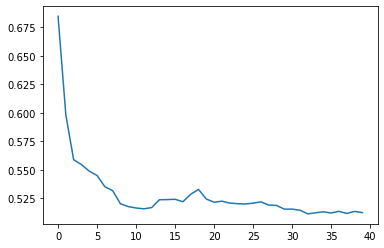

In [18]:
plt.plot(train_loss)
#plt.yscale("log")

In [19]:
auc_score = metrics.roc_auc_score(ys_true, ys_pred)

print("AUC: ", auc_score)

AUC:  0.5892399465231013


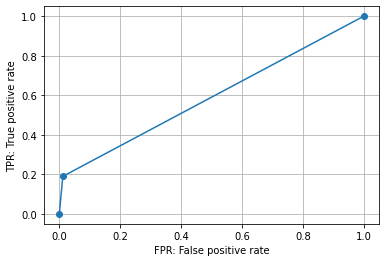

In [20]:
fpr, tpr, thresholds =  metrics.roc_curve(ys_true, ys_pred)

plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()


max acc:  0.7980618303419095


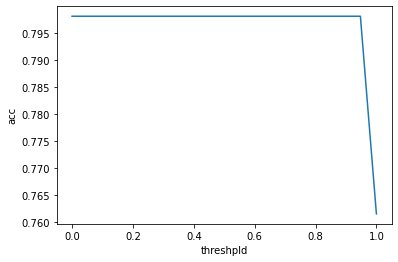

In [21]:
accs = []
thresh = np.linspace(0, 1, 20)
for t in thresh:
    test_acc = metrics.accuracy_score(ys_true, ((copy.deepcopy(np.array(ys_pred)) > t ).astype(float) ).astype(float))
    accs.append(test_acc)


plt.plot(thresh, accs)
plt.ylabel("acc")
plt.xlabel("threshpld")
print("max acc: ", np.max(accs))

とりあえずまあ、いいかぁ

In [22]:
ys_bin_pred = (ys_pred > 0.5).astype(float)

## FairLearnで公平性をチェック

In [23]:
from fairlearn.metrics import selection_rate_group_summary
from fairlearn.widget import FairlearnDashboard
from fairlearn.metrics import group_summary

In [24]:
print(len(ys_true))
print(len(ys_bin_pred))

14653
14653


In [25]:
group_summary(metrics.accuracy_score, ys_true, ys_bin_pred, sensitive_features=test_sensitive)

{'overall': 0.7980618303419095,
 'by_group': {0: 0.7433204160717928, 1: 0.9088095729317104}}

In [26]:
vanilla = selection_rate_group_summary(ys_true, ys_bin_pred, sensitive_features=test_sensitive)
print(vanilla)


{'overall': 0.0541186105234423, 'by_group': {0: 0.06587803385682235, 1: 0.030328037961625746}}


In [27]:
vanilla["B"]= 0
vanilla["test_acc"] = test_acc
print(vanilla)

{'overall': 0.0541186105234423, 'by_group': {0: 0.06587803385682235, 1: 0.030328037961625746}, 'B': 0, 'test_acc': 0.7615505357264724}


## 公平性制約

In [28]:
# 普通に学習

model= get_model()
model = model.to(device)
train_loss = []
train_acc = []
B = 1
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())
dp_loss = fairtorch.DemographicParityLoss(sensitive_classes=[0, 1,], alpha=B)

model.train()

for epo in range(epoch):
    # train 
    n_samples = 0
    total_loss = 0
    ys_true = []
    ys_pred = []
    total_correct_results_sum = 0

    for i, data in enumerate(train_loader):

        n_1iter = data["y"].size(0)
        #print(data["X"].size())
        #print(data["y"].size())

        logit = model(data["X"].to(device))
        loss = criterion(logit, data["y"].to(device)) 

        loss_whole = loss + dp_loss.forward(data["X"].to(device), logit, data["A"].to(device))
        optimizer.zero_grad()

        loss_whole.backward()

        optimizer.step()
        loss = loss.detach().cpu().float() * n_1iter
        total_loss += loss
        n_samples += n_1iter
        y_bin_pred = torch.round(F.sigmoid(logit.detach().cpu().view(-1)))
        ys_pred += y_bin_pred .view(-1).numpy().tolist()
        y_test = data["y"].cpu()
        ys_true += y_test.view(-1).numpy().tolist()
        correct_results_sum = (y_bin_pred == y_test).sum().float()
        total_correct_results_sum += correct_results_sum

    total_loss /= n_samples
    print("epoch: {}    loss {:.5f}".format(epo, total_loss))
    train_loss.append(float(total_loss.float()))
    train_acc.append(float(total_correct_results_sum/n_samples))

# test 
model.eval()
with torch.no_grad():
    test_loss = 0   
    total_loss =0
    total_correct_results_sum = 0
    n_samples = 0
    ys_true = []
    ys_pred = []
    test_sensitive = []
    for i, data in enumerate(test_loader):
        n_1iter = data["y"].size(0)
        test_sensitive += list(data["A"].cpu().numpy())
        optimizer.zero_grad()
        #print(data["X"].size())
        logit = model(data["X"].to(device))
        loss = criterion(logit, data["y"].to(device))
        optimizer.step()
        loss = loss.detach().cpu().float() * n_1iter
        total_loss += loss

        y_bin_pred = torch.round(F.sigmoid(logit.detach().cpu().view(-1)))
        ys_pred += y_bin_pred .view(-1).numpy().tolist()
        y_test = data["y"].cpu()
        ys_true += y_test.view(-1).numpy().tolist()
        correct_results_sum = (y_bin_pred == y_test).sum().float()
        total_correct_results_sum += correct_results_sum
        n_samples += n_1iter
ys_pred = np.asarray(ys_pred)
ys_true = np.asarray(ys_true)

total_loss /= n_samples
test_loss = total_loss
test_acc = metrics.accuracy_score(ys_true, np.round(ys_pred))
ys_bin_pred = (ys_pred > 0.5).astype(float)


epoch: 0    loss 114.31713
epoch: 1    loss 1.58867
epoch: 2    loss 0.84810
epoch: 3    loss 0.73358
epoch: 4    loss 0.67650
epoch: 5    loss 0.63937
epoch: 6    loss 0.62160
epoch: 7    loss 0.59994
epoch: 8    loss 0.58813
epoch: 9    loss 0.57928
epoch: 10    loss 0.57369
epoch: 11    loss 0.56790
epoch: 12    loss 0.56440
epoch: 13    loss 0.56724
epoch: 14    loss 0.56313
epoch: 15    loss 0.56560
epoch: 16    loss 0.56289
epoch: 17    loss 0.56032
epoch: 18    loss 0.55689
epoch: 19    loss 0.55671
epoch: 20    loss 0.56013
epoch: 21    loss 0.55513
epoch: 22    loss 0.55357
epoch: 23    loss 0.55628
epoch: 24    loss 0.55634
epoch: 25    loss 0.56187
epoch: 26    loss 0.55440
epoch: 27    loss 0.55647
epoch: 28    loss 0.55246
epoch: 29    loss 0.55303
epoch: 30    loss 0.55535
epoch: 31    loss 0.55356
epoch: 32    loss 0.55261
epoch: 33    loss 0.55511
epoch: 34    loss 0.55164
epoch: 35    loss 0.55195
epoch: 36    loss 0.55039
epoch: 37    loss 0.55055
epoch: 38    loss 0.

train BCE loss: [114.31713104248047, 1.5886714458465576, 0.8480953574180603, 0.7335821986198425, 0.6765009760856628, 0.6393696069717407, 0.62160325050354, 0.5999360680580139, 0.5881347060203552, 0.5792754888534546, 0.5736944079399109, 0.5678995251655579, 0.5644041299819946, 0.567237138748169, 0.5631285905838013, 0.565601646900177, 0.5628873109817505, 0.5603153109550476, 0.5568933486938477, 0.5567104816436768, 0.5601266026496887, 0.5551292300224304, 0.5535739660263062, 0.5562800168991089, 0.5563350319862366, 0.5618723630905151, 0.5543981790542603, 0.5564668774604797, 0.552461564540863, 0.5530328750610352, 0.5553512573242188, 0.5535562038421631, 0.5526096224784851, 0.5551124811172485, 0.5516356229782104, 0.5519534945487976, 0.5503943562507629, 0.5505469441413879, 0.549056887626648, 0.5506259202957153]
test Acc: [653.6973266601562, 711.7130126953125, 752.7973022460938, 760.0685424804688, 763.9404296875, 765.967529296875, 766.8543701171875, 768.6527099609375, 768.9263916015625, 769.5031738

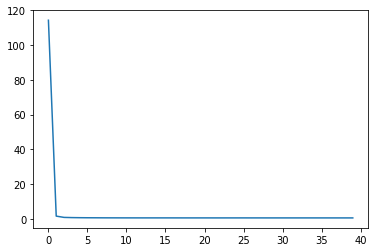

In [29]:
print("train BCE loss: {}".format(train_loss))
print("test Acc: {}".format(train_acc))
print("test BCE loss: {}".format(test_loss))
print("test Acc: {}".format(test_acc))

plt.plot(train_loss)
#plt.yscale("log")

dp_const = selection_rate_group_summary(ys_true, ys_bin_pred, sensitive_features=test_sensitive)
dp_const["B"]= B
dp_const["test_acc"] = test_acc
print(dp_const)


<BarContainer object of 2 artists>

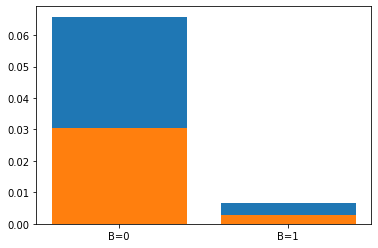

In [30]:
# 可視化

selerate_A0 = [vanilla['by_group'][0], dp_const['by_group'][0]]
selerate_A1 = [vanilla['by_group'][1], dp_const['by_group'][1]]

label0  = ["B=0", "B=1"]
label1  = ["B=0", "B=1"]


plt.bar(label0, selerate_A0)
plt.bar(label1, selerate_A1)

<BarContainer object of 2 artists>

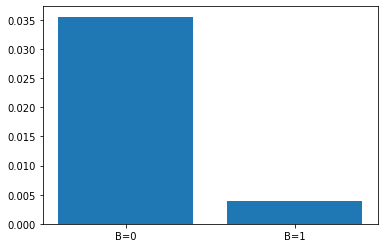

In [31]:
selerate_A0 = np.array([vanilla['by_group'][0], dp_const['by_group'][0]])
selerate_A1 = np.array([vanilla['by_group'][1], dp_const['by_group'][1]])

label0  = ["B=0", "B=1"]
label1  = ["B=0", "B=1"]


plt.bar(label0, np.abs(selerate_A0-selerate_A1))


In [32]:
data_res = [[vanilla["B"],"vanilla", vanilla["by_group"][0],vanilla["by_group"][1] ],
            [dp_const["B"], "DP constraint", dp_const["by_group"][0], dp_const["by_group"][1]]
]

df = pd.DataFrame(data_res, columns=["B", "label", "male: A=O", "female: A=1"])
df.set_index("label")

,B,selection rate: A=O,selection rate: A=1
label,,,
vanilla,0.0,0.065878,0.030328
DP constraint,0.5,0.006731,0.002888


In [33]:
df

,B,label,selection rate: A=O,selection rate: A=1
0,0.0,vanilla,0.065878,0.030328
1,0.5,DP constraint,0.006731,0.002888


<Figure size 864x576 with 0 Axes>

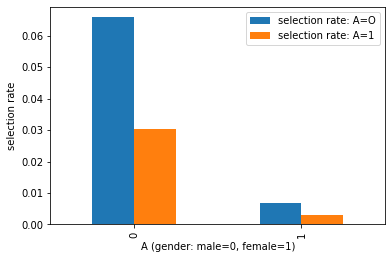

In [44]:
plt.figure(figsize=(12, 8))
df[["male: A=O", "female: A=1"]].plot.bar()
plt.ylabel("selection rate")
plt.xlabel("fairness constraint (0: no constraint, 1: Demographic parity(α=1))")
plt.show()